# Visualize and compare all ML scores and predictions

In [1]:
#libraries needed for merging and visualization of scores
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
from IPython.display import display

#libraies needed for creating matching legends
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import rgb2hex

In [2]:
#import self-made functions
%run '/Users/mariekececilia/Documents/master_thesis_code/methods.ipynb'

In [3]:
#figure saving settings for this notebook
folder_path_figures = 'Figures/'
figure_format = 'pdf'

In [4]:
#parameters for text in math mode
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Charter' #same font as in Latex document
plt.rcParams['mathtext.it'] = 'Serif:italic' #closest to Latex font (couldn't find Charter italic font)
plt.rcParams['mathtext.bf'] = 'Serif:bold' #cloeset to Latex font (couldn't find Charter bold font)

## Load ML results

The nested dictionaries of scores and predictions stored in the other Notebooks are retrieved here. <br>
- Structure of scores dicts: <br>
    - \[target\] -> \[learning algorithm\] -> \[0\] -> dataframe of all scores of all models* with that target and learning algorithm <br>
    - \[target\] -> \[learning algorithm\] -> \[1\] -> dataframe of summary (average and std) of all scores of all models with that target and learning algorithm <br>
- Structure of preds dicts: <br>
    - \[target\] -> \[learning algorithm\] -> dataframe of all predicted values of all models* with that target and learning algorithm  + actual values <br>

\*models are named by their extraction or feature selection method

In [5]:
''' Retrieve all scores and predictions calculated in respective Notebooks:
    * 'models_PCA'
    * 'models_filter'
    * 'models_filter_strict'
    * 'models_tune_AKGDH'
    * 'models_tune_ICDHyr'
    * 'models_tune_PPC'
'''

# keys: ['R_PPC', 'R_AKGDH', 'R_ICDHyr'] -> pca_keys (see below block)
%store -r scores_pca
%store -r preds_pca

# keys: ['R_PPC', 'R_AKGDH', 'R_ICDHyr'] -> filter_first_keys (see below block)
%store -r scores_filter_first
%store -r preds_filter_first

# keys: ['R_PPC', 'R_AKGDH', 'R_ICDHyr'] -> filter_strict_keys (see below block)
%store -r scores_filter_strict
%store -r preds_filter_strict

# keys: ['R_PPC'] -> tuning_keys (see below block)
%store -r scores_tune_ppc
%store -r preds_tune_ppc

# keys: ['R_AKGDH'] -> tuning_keys (see below block)
%store -r scores_tune_akgdh
%store -r preds_tune_akgdh

# keys: ['R_ICDHyr'] -> tuning_keys (see below block)
%store -r scores_tune_icdhyr
%store -r preds_tune_icdhyr

Make lists to facilitate downstream steps:

In [6]:
# list of target keys to iterate over
targets = ['R_PPC', 
           'R_AKGDH', 
           'R_ICDHyr']

#list tuning preds together in the same order as target keys
tune_preds = [preds_tune_ppc, 
              preds_tune_akgdh, 
              preds_tune_icdhyr]

#list tuning scores together in the same order as target keys
tune_scores = [scores_tune_ppc, 
               scores_tune_akgdh, 
               scores_tune_icdhyr]

# make lists of algorithm keys to iterate over
pca_keys = ['lr', 
            'ridge_a1', 
            'lasso_a1', 
            'svr']

filter_first_keys = ['lr', 
                     'svr']

filter_strict_keys = ['lr', 
                      'lasso_a0.05',
                      'ridge_a0.05']

tune_keys = ['lr',
             'lasso_a1', 
             'lasso_a0.1', 
             'lasso_a0.05', 
             'lasso_a0.001',
             'ridge_a1',
             'ridge_a0.1',
             'ridge_a0.05',
             'ridge_a0.001']

## Merge results

### Per batch of models

In the dicts, there are one dataframe (of models with different feature extraction or selection methods) per reaction and learning algorithm combo. Here those are merged so that there is only one dataframe of all the models in the "batch" per reaction. Later ALL models (all the batches) are merged too. 

PCA batch:

In [7]:
preds_pca_merged = dict()
scores_pca_merged = dict()

for target in targets:
    
    preds = copy.deepcopy(preds_pca[target])
    scores = copy.deepcopy(scores_pca[target])
    
    #add PCs + algorithm name to column labels before merging
    for algorithm in pca_keys:
        preds[algorithm] = preds[algorithm].add_suffix('_PCs_' + algorithm)
        scores[algorithm][0] = scores[algorithm][0].add_suffix('_PCs_' + algorithm)
    
    #merge preds, skip the first column because that is 'actual' in all
    res = preds['lr'].join(preds['ridge_a1'].iloc[:,1:])
    res = res.join(preds['lasso_a1'].iloc[:,1:])
    res = res.join(preds['svr'].iloc[:,1:])
    res.columns = res.columns.str.replace('actual_PCs_lr', 'actual')
    preds_pca_merged[target] = res
    
    #merge scores
    res2 = scores['lr'][0].join(scores['ridge_a1'][0])
    res2 = res2.join(scores['lasso_a1'][0])
    res2 = res2.join(scores['svr'][0])
    scores_pca_merged[target] = res2

Filter (first) batch:

In [8]:
preds_filter_first_merged = dict()
scores_filter_first_merged = dict()

for target in targets:
    
    preds = copy.deepcopy(preds_filter_first[target])
    scores = copy.deepcopy(scores_filter_first[target])
            
    #add algorithm name to column labels before merging
    for algorithm in filter_first_keys:
        preds[algorithm] = preds[algorithm].add_suffix('_' + algorithm)
        scores[algorithm][0] = scores[algorithm][0].add_suffix('_' + algorithm)
        
    #merge preds, skip the first column because that is 'actual' in all
    res = preds['lr'].join(preds['svr'].iloc[:,1:])
    res.columns = res.columns.str.replace('actual_lr', 'actual')
    preds_filter_first_merged[target] = res
    
    #merge scores
    res2 = scores['lr'][0].join(scores['svr'][0])
    scores_filter_first_merged[target] = res2

Filter (strict) batch:

In [9]:
preds_filter_strict_merged = dict()
scores_filter_strict_merged = dict()

for target in targets:
    
    preds = copy.deepcopy(preds_filter_strict[target])
    scores = copy.deepcopy(scores_filter_strict[target])
    
    #add algorithm name to column labels before merging
    for algorithm in filter_strict_keys:
        preds[algorithm] = preds[algorithm].add_suffix('_' + algorithm)
        scores[algorithm][0] = scores[algorithm][0].add_suffix('_' + algorithm)
        
    #merge preds, skip the first column because that is 'actual' in all
    res = preds['lr'].join(preds['lasso_a0.05'].iloc[:,1:])
    res = res.join(preds['ridge_a0.05'].iloc[:,1:])
    res.columns = res.columns.str.replace('actual_lr', 'actual')
    preds_filter_strict_merged[target] = res
    
    #merge scores
    res2 = scores['lr'][0].join(scores['lasso_a0.05'][0])
    res2 = res2.join(scores['ridge_a0.05'][0])
    scores_filter_strict_merged[target] = res2

Tuned batch:

In [10]:
preds_tune_merged = dict()
scores_tune_merged = dict()

for target, target_preds, target_scores in zip(targets, tune_preds, tune_scores):
    preds = copy.deepcopy(target_preds[target])
    scores = copy.deepcopy(target_scores[target])
    
    #add algorithm name to column labels before merging
    for algorithm in tune_keys:
        preds[algorithm] = preds[algorithm].add_suffix('_' + algorithm)
        scores[algorithm][0] = scores[algorithm][0].add_suffix('_' + algorithm)
        
    #merge preds, skip the first column because that is 'actual' in all
    res = preds['lr'].join(preds['lasso_a1'].iloc[:,1:])
    res = res.join(preds['lasso_a0.1'].iloc[:,1:])
    res = res.join(preds['lasso_a0.05'].iloc[:,1:])
    res = res.join(preds['lasso_a0.001'].iloc[:,1:])
    res = res.join(preds['ridge_a1'].iloc[:,1:])
    res = res.join(preds['ridge_a0.1'].iloc[:,1:])
    res = res.join(preds['ridge_a0.05'].iloc[:,1:])
    res = res.join(preds['ridge_a0.001'].iloc[:,1:])
    res.columns = res.columns.str.replace('actual_lr', 'actual')
    preds_tune_merged[target] = res
    
    #merge scores
    res2 = scores['lr'][0].join(scores['lasso_a1'][0])
    res2 = res2.join(scores['lasso_a0.1'][0])
    res2 = res2.join(scores['lasso_a0.05'][0])
    res2 = res2.join(scores['lasso_a0.001'][0])
    res2 = res2.join(scores['ridge_a1'][0])
    res2 = res2.join(scores['ridge_a0.1'][0])
    res2 = res2.join(scores['ridge_a0.05'][0])
    res2 = res2.join(scores['ridge_a0.001'][0])    
    scores_tune_merged[target] = res2

### All results (all batches)

**Merge all prediction dataframes (per reaction):**

In [11]:
preds_all = dict() # reaction key --> all predictions of all models + actual values

#The best model of 'filter_first' will occur in 'tune' too, and 'actual' will occur in all
print('Copies removed:')
for target in targets:
    
    #merge, tag copies
    res = preds_pca_merged[target].join(preds_filter_first_merged[target], rsuffix='_copy')
    res = res.join(preds_filter_strict_merged[target], rsuffix='_copy')
    res = res.join(preds_tune_merged[target], rsuffix='_copy')
    
    #remove copies
    copies = []
    for col in res.columns:
        if '_copy' in col:
            copies.append(col)
    res = res.drop(copies, axis = 1)
    print(copies)
    
    #add merged df to dictionary
    preds_all[target] = res
    
    #write results to file
    np.round(res,3).to_csv('Tables/CV_predictions_' + target[2:] + '.csv', sep = ',') 

Copies removed:
['actual_copy', 'actual_copy', 'actual_copy', 'v10_f10_lr_copy']
['actual_copy', 'actual_copy', 'actual_copy', 'v20_mi20_lr_copy']
['actual_copy', 'actual_copy', 'actual_copy', 'v20_mi20_lr_copy']


**Merge all score dataframes (per reaction):**

In [12]:
scores_all = dict() # reaction key --> all scores of all models

#The best model of 'filter_first' will occur in 'tune' too
print('Copies removed:')
for target in targets:
    #merge, tag copies
    res = scores_pca_merged[target].join(scores_filter_first_merged[target])
    res = res.join(scores_filter_strict_merged[target])
    res = res.join(scores_tune_merged[target], rsuffix='_copy')
    
    #remove copies
    copies = []
    for col in res.columns:
        if '_copy' in col:
            copies.append(col)
    res = res.drop(copies, axis = 1)
    print(copies)
    
    #add merged df to dictionary
    scores_all[target] = res
    
    #write results to file
    np.round(res,4).to_csv('Tables/CV_scores_' + target[2:] + '.csv', sep = ',')

Copies removed:
['v10_f10_lr_copy']
['v20_mi20_lr_copy']
['v20_mi20_lr_copy']


**Find all averages and std of merged dataframes (easier than merging all summary dataframes):**

In [13]:
#make a df of all summaries: reaction key --> df of models, their average MAPE and std (sorted by lowest average)
scores_all_summary = dict()

for target in targets:
    #find all means and std
    model_names = scores_all[target].columns
    model_means = scores_all[target].mean().tolist()
    model_std = scores_all[target].std().tolist()
    res = pd.DataFrame(zip(model_names, model_means, model_std), 
                       columns = ['model', 'average', 'std'])
    res = res.sort_values(by = 'average')
    scores_all_summary[target] = res
    
    #write results to file
    #use sep = '_' to match delimiter in model name, but still not automated because different steps involved in different models
    np.round(res,4).to_csv('Tables/score_summaries_' + target[2:] + '.csv', sep = ',', index = False) 

## Best of all models

In [14]:
# find the name of the model with lowest average score for each reaction

best_model = dict() #dictionary: [target] -> name of best model

for target in sorted(targets):
    #locate first entry, scores_all_summary dataframes are sorted by average
    best = scores_all_summary[target].iloc[0,0]
    #add name to dict
    best_model[target] = best
    
    #print the best model and the 4 next best
    print(target+':')
    print('best model is', best)
    res = scores_all_summary[target].copy()
    res[['average', 'std']] = np.round(res[['average', 'std']],4)
    display(res.head(5))

R_AKGDH:
best model is v20_mi20_lasso_a0.1


,model,average,std
86,v20_mi20_lasso_a0.1,0.6717,1.3856
93,v20_mi30_lasso_a0.001,0.7165,0.6786
89,v20_mi20_lasso_a0.05,0.7387,1.2496
85,v20_mi15_lasso_a0.1,0.7663,1.6917
88,v20_mi15_lasso_a0.05,0.8257,1.6206


R_ICDHyr:
best model is v20_mi30_lasso_a0.001


,model,average,std
93,v20_mi30_lasso_a0.001,0.1948,0.0885
92,v20_mi20_lasso_a0.001,0.2267,0.3169
89,v20_mi20_lasso_a0.05,0.2792,0.2116
103,v20_mi15_ridge_a0.001,0.2802,0.3860
80,v20_mi15_lr,0.2817,0.3868


R_PPC:
best model is v10_f10_lasso_a0.05


,model,average,std
89,v10_f10_lasso_a0.05,0.0988,0.1006
90,v10_f5_lasso_a0.05,0.1262,0.1652
86,v10_f10_lasso_a0.1,0.1342,0.1540
102,v10_f5_ridge_a0.05,0.1384,0.2019
99,v10_f5_ridge_a0.1,0.1457,0.2036


### MAPE scores of best model

In [15]:
for target in sorted(targets):
    best = best_model[target]
    print('Target:', target)
    print('Model with the lowest average MAPE:', best)
    print('All MAPE scores of that model (sorted from best to worst):')
    display(np.round(scores_all[target][best].sort_values(),4))
    print()

Target: R_AKGDH
Model with the lowest average MAPE: v20_mi20_lasso_a0.1
All MAPE scores of that model (sorted from best to worst):


Test set
Glycerol     0.0230
Acetate      0.0258
Galactose    0.0493
Glucose      0.0655
Succinate    0.1539
Pyruvate     0.4934
Fructose     0.4971
Gluconate    4.0652
Name: v20_mi20_lasso_a0.1, dtype: float64


Target: R_ICDHyr
Model with the lowest average MAPE: v20_mi30_lasso_a0.001
All MAPE scores of that model (sorted from best to worst):


Test set
Fructose     0.0847
Succinate    0.1026
Glycerol     0.1578
Glucose      0.1764
Gluconate    0.1840
Acetate      0.2103
Pyruvate     0.3107
Galactose    0.3317
Name: v20_mi30_lasso_a0.001, dtype: float64


Target: R_PPC
Model with the lowest average MAPE: v10_f10_lasso_a0.05
All MAPE scores of that model (sorted from best to worst):


Test set
Succinate    0.0080
Pyruvate     0.0205
Glycerol     0.0251
Acetate      0.0294
Gluconate    0.0824
Glucose      0.1270
Galactose    0.2445
Fructose     0.2533
Name: v10_f10_lasso_a0.05, dtype: float64

### Predictions of best model

In [16]:
for target in sorted(targets):
    print('Target:', target)
    print('Predictions of the model with the lowest average MAPE:')
    display(np.round(preds_all[target][['actual', best_model[target]]],3))
    print()

Target: R_AKGDH
Predictions of the model with the lowest average MAPE:


,actual,v20_mi20_lasso_a0.1
Acetate,4.267,4.377
Fructose,3.875,5.801
Galactose,0.236,0.248
Glucose,2.138,1.998
Glycerol,1.840,1.883
Gluconate,0.182,0.924
Pyruvate,7.416,3.757
Succinate,2.352,1.990



Target: R_ICDHyr
Predictions of the model with the lowest average MAPE:


,actual,v20_mi30_lasso_a0.001
Acetate,4.696,3.709
Fructose,4.566,4.953
Galactose,0.496,0.661
Glucose,2.978,2.453
Glycerol,2.465,2.076
Gluconate,1.154,0.942
Pyruvate,7.979,5.500
Succinate,3.039,2.727



Target: R_PPC
Predictions of the model with the lowest average MAPE:


,actual,v10_f10_lasso_a0.05
Acetate,1.774,1.722
Fructose,3.546,2.648
Galactose,0.377,0.470
Glucose,2.453,2.142
Glycerol,1.376,1.342
Gluconate,1.943,1.783
Pyruvate,2.489,2.541
Succinate,2.016,2.032


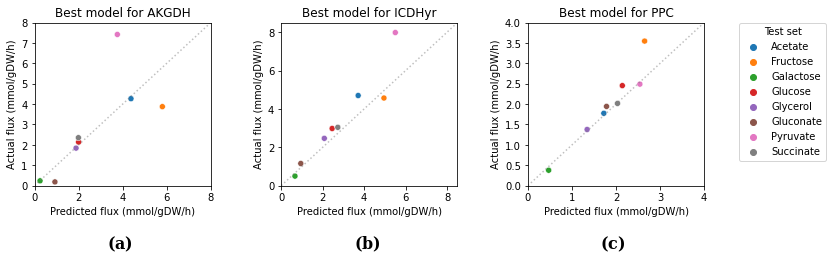

In [17]:
#plot actual vs predicted 

preds = copy.deepcopy(preds_all)

#subplot arrangement and figure size (scale)
nrows = 1
ncols = 3
scale = 3

#titles and outputs
score_in_title = False #if true, show average and std under subplot-title
suptitle = 'Predicted values vs. actual values'
figure_name = 'preds_best_models'
plot_captions = []

#------------------------- Actual plotting -----------------------------------------

#create figure and fill in subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,3), sharex = False, sharey = False)

#------------------------- Subplots ------------------------------------------------
for target, ax in zip(sorted(targets), fig.axes):

    name = best_model[target]
    y_col = 'actual'
    data = preds[target]

    #hue/legend settings:
    hue = 'Test set'
    data[hue] = data.index    
    palette = 'tab10' 

    #axes range
    lowest = 0
    if 'PPC' in target:
        highest = 4
    if 'AKGDH' in target:
        highest = 8
    if 'ICDHyr' in target:
        highest = 8.5

    #plot data
    #diagonal
    ax.plot([lowest, highest], [lowest, highest], linestyle = 'dotted', color = 'grey', alpha = 0.5)
    #scatter
    ax = sns.scatterplot(x=name, 
                         y=y_col, 
                         data=data, 
                         ax = ax,
                         hue = hue,
                         palette = palette,
                         )
    if (ax.get_legend() != None): ax.get_legend().remove()
    ax.set_xlim(lowest, highest)
    ax.set_ylim(lowest, highest)
    ax.set_ylabel('Actual flux (mmol/gDW/h)')
    ax.set_xlabel('Predicted flux (mmol/gDW/h)')

    #keep legend for later
    handles, labels = ax.get_legend_handles_labels()

    #set title
    if (score_in_title):
        title = ('Best model for ' + target[2:] + ':\n' 
                 + name 
                 + '\n average MAPE: ' + str(round(scores_all[target][name].mean(),4)) 
                 + '\n std: ' + str(round(scores_all[target][name].std(),4))
                )
    else: 
        title = ('Best model for ' + target[2:]
                 #+ ':\n' + name
                )
    ax.set_title(title)
    #ax.set_title(name)
    plot_captions.append(title)

#------------------------- Common for figure ------------------------------------------


#add legend
axes[2].legend(handles, 
               labels, 
               loc = 2,
               bbox_to_anchor= (1.2, 1),
               #loc = 4, #above, right
               #bbox_to_anchor = (1, 1.2), #above, right
               borderaxespad=0.,
               ncol=1,
               title = hue,
              )

#add plot numbering
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
                r'$\bf{(c)}$',
               ]
plot_captions = ['','','','','','',''] #when titles instead of cpations
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(.41, -.3, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )

#add title and adjust spacings
#plt.suptitle(suptitle, fontweight='bold', y = 1.15)
plt.subplots_adjust(wspace=0.4, hspace=0.3) #width and height between subplots

#save figure
plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)),
            format=figure_format, 
            dpi=200,
            facecolor = 'white',
            bbox_inches='tight', #include the legend 
         )
plt.show()
plt.close()

## Average score per test sample

In [18]:
for target in targets:
    print('\nAverage score for each test set across all models:')
    print(np.round(scores_all[target].T.mean(),4))


Average score for each test set across all models:
Test set
Acetate      0.2050
Fructose     0.3338
Galactose    2.6837
Glucose      0.1349
Glycerol     0.2433
Gluconate    0.1223
Pyruvate     0.2092
Succinate    0.1092
dtype: float64

Average score for each test set across all models:
Test set
Acetate       0.2001
Fructose      0.2960
Galactose     7.0866
Glucose       0.4599
Glycerol      0.2303
Gluconate    10.0507
Pyruvate      0.5078
Succinate     0.2363
dtype: float64

Average score for each test set across all models:
Test set
Acetate      0.1840
Fructose     0.3638
Galactose    3.7033
Glucose      0.3084
Glycerol     0.1930
Gluconate    1.3915
Pyruvate     0.4507
Succinate    0.1265
dtype: float64


## Compare scores

### Best of each batch

#### Best of PCA models

In [19]:
print('Best of PCA')
for target in sorted(targets):
    res = pd.DataFrame(zip(scores_pca_merged[target].columns, 
                           scores_pca_merged[target].mean().tolist(), 
                           scores_pca_merged[target].std().tolist()), 
                       columns = ['model', 'average', 'std'])
    res = res.sort_values(by = 'average')
    print(target+':')
    display(res.head())

Best of PCA
R_AKGDH:


,model,average,std
2,3_PCs_lr,2.003519,3.369582
9,3_PCs_ridge_a1,2.003776,3.370096
16,3_PCs_lasso_a1,2.070428,3.484857
4,5_PCs_lr,2.165815,3.813331
11,5_PCs_ridge_a1,2.166011,3.813675


R_ICDHyr:


,model,average,std
2,3_PCs_lr,0.709891,1.006558
9,3_PCs_ridge_a1,0.709964,1.006776
4,5_PCs_lr,0.730105,1.037512
11,5_PCs_ridge_a1,0.730178,1.037726
16,3_PCs_lasso_a1,0.732127,1.058998


R_PPC:


,model,average,std
6,7_PCs_lr,0.297126,0.470110
5,6_PCs_lr,0.297126,0.470110
13,7_PCs_ridge_a1,0.297202,0.470308
12,6_PCs_ridge_a1,0.297202,0.470308
4,5_PCs_lr,0.310365,0.503699


#### Best of filter (first)

In [20]:
print('Best of first selection methods')
for target in sorted(targets):
    res = pd.DataFrame(zip(scores_filter_first_merged[target].columns, 
                           scores_filter_first_merged[target].mean().tolist(), 
                           scores_filter_first_merged[target].std().tolist()), 
                       columns = ['model', 'average', 'std'])
    res = res.sort_values(by = 'average')
    print(target+':')
    display(res.head())

Best of first selection methods
R_AKGDH:


,model,average,std
9,v20_mi20_lr,0.897167,1.698628
3,v10_f10_lr,0.950969,1.468945
8,v20_f10_lr,1.131259,1.500553
7,v20_mi10_lr,1.136071,1.663893
10,v20_f20_lr,1.168169,1.978159


R_ICDHyr:


,model,average,std
9,v20_mi20_lr,0.359214,0.330940
8,v20_f10_lr,0.469866,0.391353
4,v10_mi20_lr,0.504877,0.578159
7,v20_mi10_lr,0.510470,0.313144
10,v20_f20_lr,0.540485,0.454524


R_PPC:


,model,average,std
3,v10_f10_lr,0.165893,0.065502
0,noSelection_lr,0.288090,0.380886
1,v10_lr,0.291417,0.390523
6,v20_lr,0.298487,0.390557
5,v10_f20_lr,0.348834,0.618957


#### Best of filter (strict)

In [21]:
print('Best of strict variance filter')
for target in sorted(targets):
    res = pd.DataFrame(zip(scores_filter_strict_merged[target].columns, 
                           scores_filter_strict_merged[target].mean().tolist(), 
                           scores_filter_strict_merged[target].std().tolist()), 
                       columns = ['model', 'average', 'std'])
    res = res.sort_values(by = 'average')
    print(target+':')
    display(res.head())

Best of strict variance filter
R_AKGDH:


,model,average,std
22,v50_f10_ridge_a0.05,1.247067,2.243319
0,v50_lr,1.367532,2.099079
20,v50_ridge_a0.05,1.367632,2.099285
2,v50_f10_lr,1.513817,2.509648
12,v50_f10_lasso_a0.05,1.662481,2.533969


R_ICDHyr:


,model,average,std
24,v50_f20_ridge_a0.05,0.342765,0.406777
4,v50_f20_lr,0.392422,0.436925
14,v50_f20_lasso_a0.05,0.475671,0.462722
2,v50_f10_lr,0.554561,0.743096
22,v50_f10_ridge_a0.05,0.574820,0.657644


R_PPC:


,model,average,std
0,v50_lr,0.277279,0.332291
20,v50_ridge_a0.05,0.277312,0.332386
14,v50_f20_lasso_a0.05,0.345134,0.526405
24,v50_f20_ridge_a0.05,0.407472,0.712669
10,v50_lasso_a0.05,0.410549,0.584297


#### Best of tuned models

In [22]:
print('Best of tuned models')
for target in sorted(targets):
    res = pd.DataFrame(zip(scores_tune_merged[target].columns, 
                           scores_tune_merged[target].mean().tolist(), 
                           scores_tune_merged[target].std().tolist()), 
                       columns = ['model', 'average', 'std'])
    res = res.sort_values(by = 'average')
    print(target+':')
    display(res.head())

Best of tuned models
R_AKGDH:


,model,average,std
7,v20_mi20_lasso_a0.1,0.671654,1.385599
14,v20_mi30_lasso_a0.001,0.716547,0.678620
10,v20_mi20_lasso_a0.05,0.738723,1.249560
6,v20_mi15_lasso_a0.1,0.766337,1.691672
9,v20_mi15_lasso_a0.05,0.825745,1.620641


R_ICDHyr:


,model,average,std
14,v20_mi30_lasso_a0.001,0.194782,0.088530
13,v20_mi20_lasso_a0.001,0.226665,0.316911
10,v20_mi20_lasso_a0.05,0.279225,0.211611
24,v20_mi15_ridge_a0.001,0.280201,0.386003
0,v20_mi15_lr,0.281726,0.386789


R_PPC:


,model,average,std
10,v10_f10_lasso_a0.05,0.098784,0.100551
11,v10_f5_lasso_a0.05,0.126232,0.165169
7,v10_f10_lasso_a0.1,0.134220,0.154027
23,v10_f5_ridge_a0.05,0.138362,0.201854
20,v10_f5_ridge_a0.1,0.145706,0.203603


### Box plots

#### Make common color coding of learning algorithms

In [23]:
#find unique learning algorithms
unique = set(pca_keys + filter_first_keys + filter_strict_keys + tune_keys)

#extract enough colors from palette
colors = []
cmap = cm.get_cmap('tab10', len(unique))
for i in range(cmap.N):
    rgba = cmap(i)
    colors.append(rgb2hex(rgba))

#make a color dictionary
color_dict = dict(zip(sorted(unique), colors))    
for k, v in color_dict.items():
    print(v, k)

#1f77b4 lasso_a0.001
#ff7f0e lasso_a0.05
#2ca02c lasso_a0.1
#d62728 lasso_a1
#9467bd lr
#8c564b ridge_a0.001
#e377c2 ridge_a0.05
#7f7f7f ridge_a0.1
#bcbd22 ridge_a1
#17becf svr


#### PCA

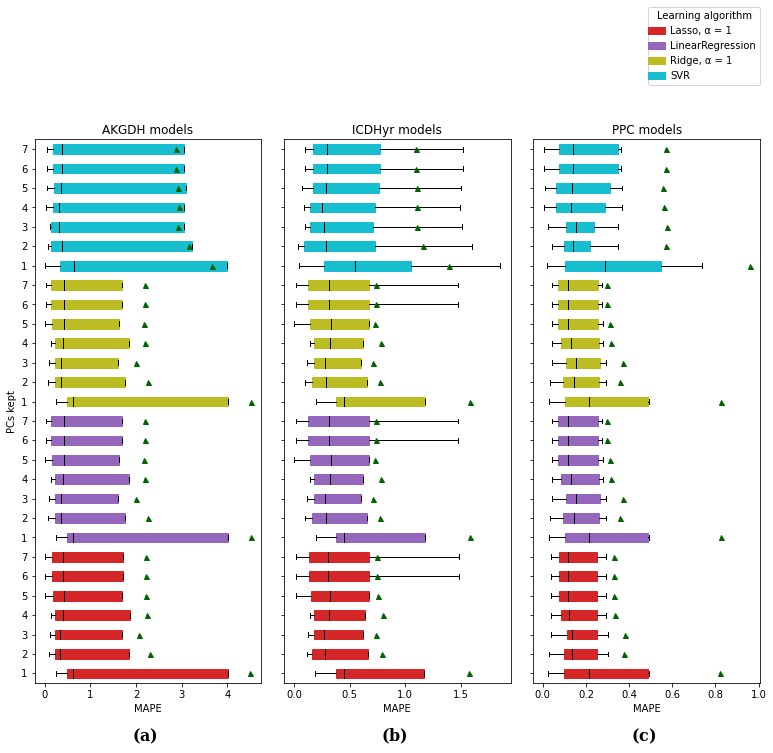

In [24]:
"""
One subplot per reaction. In each subplot, all versions of all groups are plotted,
but one color per group. 

 1. plots = reactions                      (one subplot per reaction)
 2. groups = learning algorithms           (differentiated by color)
 3. versions = features selected/extracted (differentiated by tick label)
"""

#------------------------- Parameters ----------------------------------------------
sharey = True #share y-axis, better to do manually when the labeling is done manually
score_dict = scores_pca #where to get score data from
plot_order_plots = sorted(targets) #order of subplots (reactions)
plot_order_groups = sorted(pca_keys) #order of groups (learning algorithms) in subplots
plot_order_versions = sorted(scores_pca[targets[0]][pca_keys[0]][0].columns) #order of versions (subsets)

group_description = 'Learning algorithm' #to be put in legend 
version_description = 'PCs kept' #to describe axis
suptitle = 'Scores of models with PCA dimensionality reduction'

plot_captions = []

intertwined = False #place boxplots of the same version (not group) together

if (intertwined):
    figure_name = 'scores_pca_intertwined'
else:
    figure_name = 'scores_pca_grouped'

# --------------------- Prepare to plot several groups per subplot -----------

# placement
n_groups = len(plot_order_groups)
group_length = len(plot_order_versions)
if (intertwined):
    placement = np.arange(1,(group_length*n_groups)+1, n_groups).tolist()
else:
    placement = np.arange(1,group_length+1).tolist()

# color coding
colors = []
for key in sorted(plot_order_groups):
    colors.append(color_dict[key])
    
# ----------------------- Plotting subplots for each reaction ----------------

fig, axes = plt.subplots(1, 3, figsize = (13,10))

for target, ax in zip(plot_order_plots, fig.axes):    
        
    # -.-.-.-.-.-.-.-.-.-.-. Plotting each group (learning algorithm) in subplot -.-.-.-.-.-.-.--.-.

    for i, group, color in zip(range(n_groups), plot_order_groups, colors):
        
        #update positions for versions in the group
        if (intertwined):
            positions = [x+i for x in placement]
        else:
            positions = [x+(group_length*i) for x in placement]
        
        #extract scores of the group
        cv_results_group = score_dict[target][group][0]
        
        #plot scores of the group
        draw_box_subplots(cv_results = cv_results_group[plot_order_versions], 
                          names = plot_order_versions,
                          ax = ax,
                          positions = positions,
                          boxprops=dict(facecolor=color, color=color),
                          medianprops=dict(color='black'),
                          meanprops = dict(markeredgecolor='darkgreen', 
                                           markerfacecolor='darkgreen', 
                                           markersize = '5'),
                          vert=False,
                          showfliers = False,
                          widths = 0.5,
                         )
        
    # -.-.-.-.-.-.-.-.-.-.-. Add title, ticks and labels to subplot .-.-.-.-.-.-.
    
    #update labels of y axis for all plots or the first plot when shared y axis
    if ((not sharey) | ((sharey) & (target == plot_order_plots[0]))):
        if (intertwined):
            ax.set_yticks(placement)
            ax.set_yticklabels(
                plot_order_versions, 
                #rotation = 90,
            )  
        else:
            ax.set_yticklabels(
                plot_order_versions*n_groups, 
                #rotation = 90,
            )
        ax.set_ylabel(version_description)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlabel('MAPE')
    ax.set_title(target[2:] + ' models')
    plot_captions.append(target[2:] + ' models')

# ------------------------ Common legend for figure ------------------------
   
#make legend
custom_lines = []
explanation = []
for group, color in zip(plot_order_groups, colors):
    custom_lines.append(Line2D([0], [0], color=color, lw=8))
    explanation.append(group)
    
#prettier names
explanation = [s.replace('_a', ', α = ') for s in explanation]
explanation = [s.replace('lasso', 'Lasso') for s in explanation]
explanation = [s.replace('ridge', 'Ridge') for s in explanation]
explanation = [s.replace('lr', 'LinearRegression') for s in explanation]
explanation = [s.replace('svr', 'SVR') for s in explanation]

#add legend
axes[2].legend(custom_lines, 
               explanation,
               title = group_description,
               handlelength = 1,
               #loc = 2, #right
               #bbox_to_anchor = (1.05, 1), #rigth
               loc = 4, #above, right
               bbox_to_anchor = (1, 1.1), #above, right
               borderaxespad = 0.,
          )
#-------------------- Number the plots ------------------------------------
#add plot numbering
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
                r'$\bf{(c)}$',
               ]
plot_captions = ['','','','','','',''] #when info in titles instead of captions
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(.43, -.08, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )

#-------------------- Title placement and spacing -------------------------

#plt.suptitle(suptitle, fontweight='bold', y = 0.97)
wspace = 0.1 if (sharey) else 0.3
plt.subplots_adjust(wspace=wspace, hspace=0.3) #width and height spacing

plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            )
plt.show()
plt.close()

#### Filter (first)

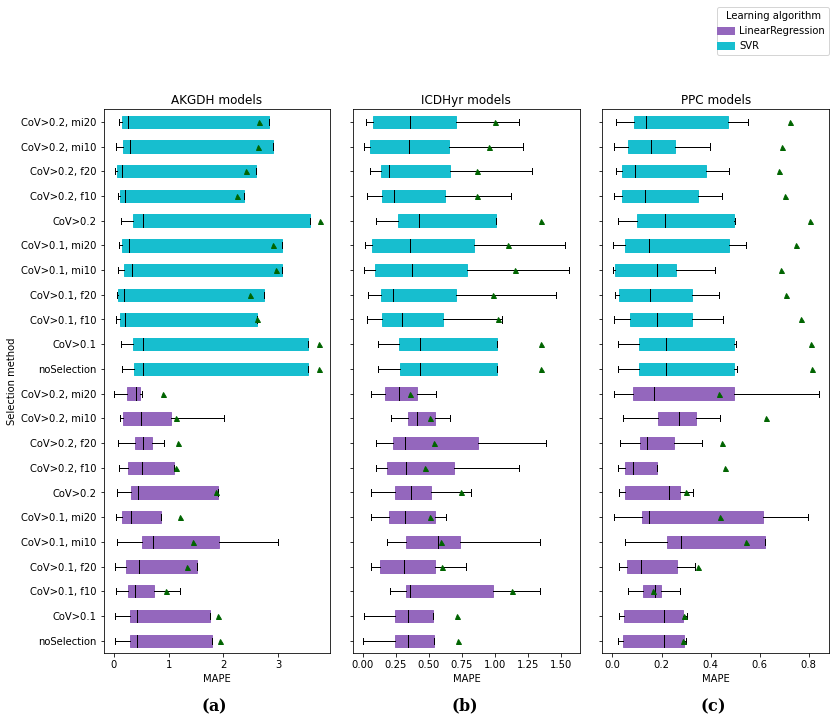

In [25]:
"""
One subplot per reaction. In each subplot, all versions of all groups are plotted,
but one color per group. 

 1. plots = reactions                      (one subplot per reaction)
 2. groups = learning algorithms           (differentiated by color)
 3. versions = features selected/extracted (differentiated by tick label)
"""

#------------------------- Parameters ----------------------------------------------
sharey = True #share y-axis, better to do manually when the labeling is done manually
score_dict = scores_filter_first #where to get score data from
plot_order_plots = sorted(targets) #order of subplots (reactions)
plot_order_groups = sorted(filter_first_keys) #order of groups (learning algorithms) in subplots
plot_order_versions = sorted(scores_filter_first[targets[0]][filter_first_keys[0]][0].columns) #order of versions (subsets)

group_description = 'Learning algorithm' #to be put in legend 
version_description = 'Selection method' #to describe axis
suptitle = 'Scores of models with various feature selection filters'
plot_captions = []

intertwined = False #place boxplots of the same version (not group) together

if (intertwined):
    figure_name = 'scores_filter_first_intertwined'
else:
    figure_name = 'scores_filter_first_grouped'

# --------------------- Prepare to plot several groups per subplot -----------

# placement
n_groups = len(plot_order_groups)
group_length = len(plot_order_versions)
if (intertwined):
    placement = np.arange(1,(group_length*n_groups)+1, n_groups).tolist()
else:
    placement = np.arange(1,group_length+1).tolist()

# color coding
colors = []
for key in sorted(plot_order_groups):
    colors.append(color_dict[key])
    
# ----------------------- Plotting subplots for each reaction ----------------

fig, axes = plt.subplots(1, 3, figsize = (13,10))

for target, ax in zip(plot_order_plots, fig.axes):    
        
    # -.-.-.-.-.-.-.-.-.-.-. Plotting each group (learning algorithm) in subplot -.-.-.-.-.-.-.--.-.

    for i, group, color in zip(range(n_groups), plot_order_groups, colors):
       
        #update positions for versions in the group
        if (intertwined):
            positions = [x+i for x in placement]
        else:
            positions = [x+(group_length*i) for x in placement]
        
        #extract scores of the group
        cv_results_group = score_dict[target][group][0]
        
        #plot scores of the group
        draw_box_subplots(cv_results = cv_results_group[plot_order_versions], 
                          names = plot_order_versions,
                          ax = ax,
                          positions = positions,
                          boxprops=dict(facecolor=color, color=color),
                          medianprops=dict(color='black'),
                          meanprops = dict(markeredgecolor='darkgreen', 
                                           markerfacecolor='darkgreen', 
                                           markersize = '5'),
                          vert=False,
                          showfliers = False,
                          widths = 0.5,
                         )
        
    # -.-.-.-.-.-.-.-.-.-.-. Add title, ticks and labels to subplot .-.-.-.-.-.-.
    
    #update labels of y axis for all plots or the first plot when shared y axis
    if ((not sharey) | ((sharey) & (target == plot_order_plots[0]))):
        #reformat label names
        labels = plot_order_versions.copy()
        labels = [s.replace('v10', 'CoV>0.1') for s in labels]
        labels = [s.replace('v20', 'CoV>0.2') for s in labels]
        labels = [s.replace('_', ', ') for s in labels]
        if (intertwined):
            ax.set_yticks(placement)
            ax.set_yticklabels(
                labels, 
                #rotation = 90,
            )  
        else:
            ax.set_yticklabels(
                labels*n_groups, 
                #rotation = 90,
            )
        ax.set_ylabel(version_description)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlabel('MAPE')
    ax.set_title(target[2:] + ' models')
    plot_captions.append(target[2:] + ' models')

# ------------------------ Common legend for figure ------------------------
   
#make legend
custom_lines = []
explanation = []
for group, color in zip(plot_order_groups, colors):
    custom_lines.append(Line2D([0], [0], color=color, lw=8))
    explanation.append(group)
    
#prettier names
explanation = [s.replace('lr', 'LinearRegression') for s in explanation]
explanation = [s.replace('svr', 'SVR') for s in explanation]

#add legend
axes[2].legend(custom_lines, 
               explanation,
               title = group_description,
               handlelength = 1,
               #loc = 2, #right
               #bbox_to_anchor = (1.05, 1), #rigth
               loc = 4, #above, right
               bbox_to_anchor = (1, 1.1), #above, right
               borderaxespad = 0.,
          )
#-------------------- Number the plots ------------------------------------
#add plot numbering
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
                r'$\bf{(c)}$',
               ]
plot_captions = ['','','','','','',''] #when info in titles instead of captions
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(.43, -.08, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )

#--------------------------------- Title placement and spacing ------------

#plt.suptitle(suptitle, fontweight='bold', y = 0.97)
wspace = 0.1 if sharey else 0.6
plt.subplots_adjust(wspace=wspace, hspace=0.5) #width and height spacing

plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            )
plt.show()
plt.close()

#### Filter (strict)

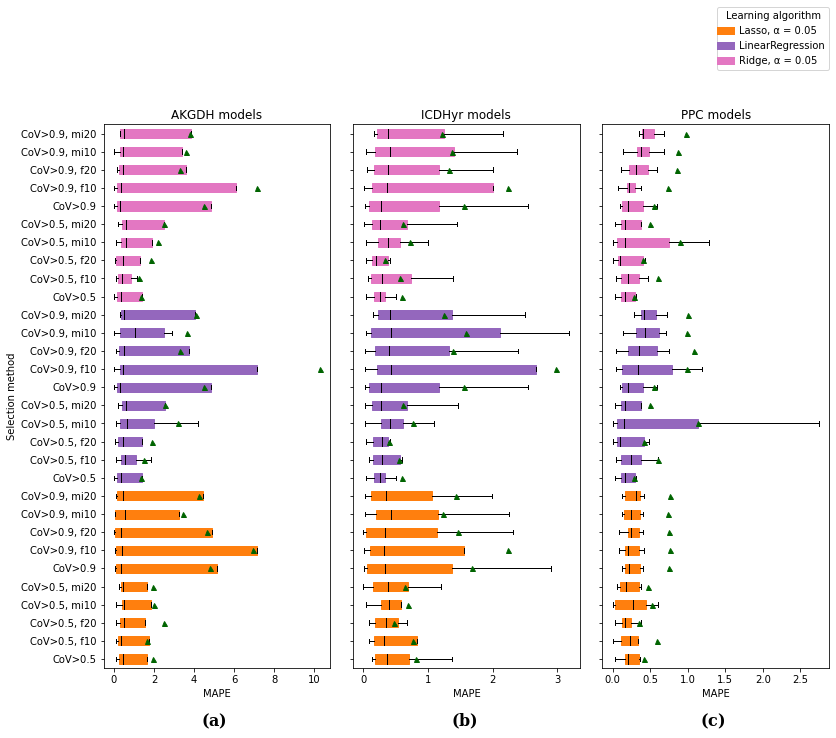

In [26]:
"""
One subplot per reaction. In each subplot, all versions of all groups are plotted,
but one color per group. 

 1. plots = reactions                      (one subplot per reaction)
 2. groups = learning algorithms           (differentiated by color)
 3. versions = features selected/extracted (differentiated by tick label)
"""

#------------------------- Parameters ----------------------------------------------
sharey = True #share y-axis, better to do manually when the labeling is done manually
score_dict = scores_filter_strict #where to get score data from
plot_order_plots = sorted(targets) #order of subplots (reactions)
plot_order_groups = sorted(filter_strict_keys) #order of groups (learning algorithms) in subplots
plot_order_versions = sorted(scores_filter_strict[targets[0]][filter_strict_keys[0]][0].columns) #order of versions (subsets)

group_description = 'Learning algorithm' #to be put in legend 
version_description = 'Selection method' #to describe axis
suptitle = 'Scores of models with strict CoV filter'
plot_captions = []

intertwined = False #place boxplots of the same version (not group) together

if (intertwined):
    figure_name = 'scores_filter_strict_intertwined'
else:
    figure_name = 'scores_filter_strict_grouped'

# --------------------- Prepare to plot several groups per subplot -----------

# placement
n_groups = len(plot_order_groups)
group_length = len(plot_order_versions)
if (intertwined):
    placement = np.arange(1,(group_length*n_groups)+1, n_groups).tolist()
else:
    placement = np.arange(1,group_length+1).tolist()

# color coding
colors = []
for key in sorted(plot_order_groups):
    colors.append(color_dict[key])
    
# ----------------------- Plotting subplots for each reaction ----------------

fig, axes = plt.subplots(1, 3, figsize = (13,10))

for target, ax in zip(plot_order_plots, fig.axes):    
        
    # -.-.-.-.-.-.-.-.-.-.-. Plotting each group (learning algorithm) in subplot -.-.-.-.-.-.-.--.-.

    for i, group, color in zip(range(n_groups), plot_order_groups, colors):
        
        #update positions for versions in the group
        if (intertwined):
            positions = [x+i for x in placement]
        else:
            positions = [x+(group_length*i) for x in placement]
        
        #extract scores of the group
        cv_results_group = score_dict[target][group][0]
        
        #plot scores of the group
        draw_box_subplots(cv_results = cv_results_group[plot_order_versions], 
                          names = plot_order_versions,
                          ax = ax,
                          positions = positions,
                          boxprops=dict(facecolor=color, color=color),
                          medianprops=dict(color='black'),
                          meanprops = dict(markeredgecolor='darkgreen', 
                                           markerfacecolor='darkgreen', 
                                           markersize = '5'),
                          vert=False,
                          showfliers = False,
                          widths = 0.5,
                         )
        
    # -.-.-.-.-.-.-.-.-.-.-. Add title, ticks and labels to subplot .-.-.-.-.-.-.
    
    #update labels of y axis for all plots or the first plot when shared y axis
    if ((not sharey) | ((sharey) & (target == plot_order_plots[0]))):
        #reformat label names
        labels = plot_order_versions.copy()
        labels = [s.replace('v50', 'CoV>0.5') for s in labels]
        labels = [s.replace('v90', 'CoV>0.9') for s in labels]
        labels = [s.replace('_', ', ') for s in labels]
        if (intertwined):
            ax.set_yticks(placement)
            ax.set_yticklabels(
                labels, 
                #rotation = 90,
            )  
        else:
            ax.set_yticklabels(
                labels*n_groups, 
                #rotation = 90,
            )
        ax.set_ylabel(version_description)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlabel('MAPE')
    ax.set_title(target[2:] + ' models')
    plot_captions.append(target[2:] + ' models')


# ------------------------ Common legend for figure ------------------------
   
#make legend
custom_lines = []
explanation = []
for group, color in zip(plot_order_groups, colors):
    custom_lines.append(Line2D([0], [0], color=color, lw=8))
    explanation.append(group)
    
#prettier names
explanation = [s.replace('_a', ', α = ') for s in explanation]
explanation = [s.replace('lasso', 'Lasso') for s in explanation]
explanation = [s.replace('ridge', 'Ridge') for s in explanation]
explanation = [s.replace('lr', 'LinearRegression') for s in explanation]

#add legend
axes[2].legend(custom_lines, 
               explanation,
               title = group_description,
               handlelength = 1,
               #loc = 2, #right
               #bbox_to_anchor = (1.05, 1), #rigth
               loc = 4, #above, right
               bbox_to_anchor = (1, 1.1), #above, right
               borderaxespad = 0.,
          )
#-------------------- Number the plots ------------------------------------
#add plot numbering
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
                r'$\bf{(c)}$',
               ]
plot_captions = ['','','','','','',''] #when info in titles instead of captions
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(.43, -.08, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )

#--------------------------------- Title placement and spacing ------------

#plt.suptitle(suptitle, fontweight='bold', y = 0.97)
wspace = 0.1 if sharey else 0.5
plt.subplots_adjust(wspace=wspace, hspace=0.4) #width and height spacing

plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            )
plt.show()
plt.close()

#### Tune

In [27]:
scores_tune_all = dict()
scores_tune_all['R_PPC'] = copy.deepcopy(scores_tune_ppc['R_PPC'])
scores_tune_all['R_AKGDH'] = copy.deepcopy(scores_tune_akgdh['R_AKGDH'])
scores_tune_all['R_ICDHyr'] = copy.deepcopy(scores_tune_icdhyr['R_ICDHyr'])

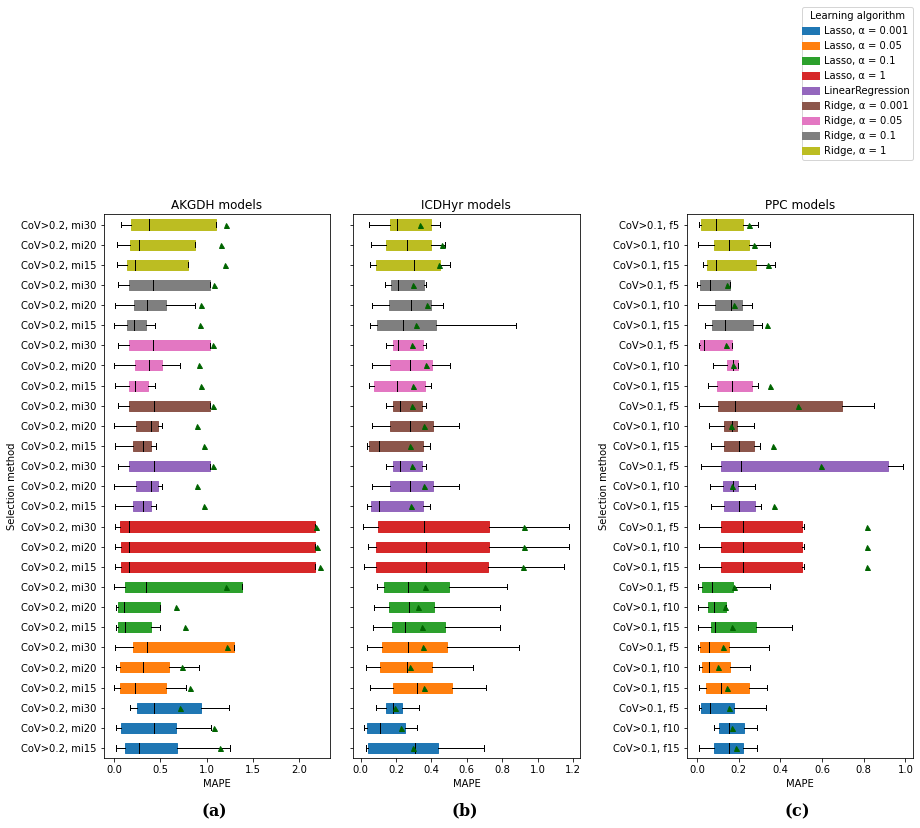

In [28]:
"""
One subplot per reaction. In each subplot, all versions of all groups are plotted,
but one color per group. 

 1. plots = reactions                      (one subplot per reaction)
 2. groups = learning algorithms           (differentiated by color)
 3. versions = features selected/extracted (differentiated by tick label)
"""

#------------------------- Parameters ----------------------------------------------
sharey = True #share y-axis, but only AKGDH and ICDHyr can share axis !
score_dict = scores_tune_all #where to get score data from
plot_order_plots = sorted(targets) #order of subplots (reactions) NB! must be sorted when sharey = True
plot_order_groups = sorted(tune_keys) #order of groups (learning algorithms) in subplots
#plot_order_version varies with reaction -> defined inside loop

group_description = 'Learning algorithm' #to be put in legend 
version_description = 'Selection method' #to describe axis
suptitle = 'Scores of tuned models'
plot_captions = []

intertwined = False #place boxplots of the same version (not group) together

if (intertwined):
    figure_name = 'scores_tune_intertwined'
else:
    figure_name = 'scores_tune_grouped'

# ----------------------- Plotting subplots for each reaction ----------------

fig, axes = plt.subplots(1, 3, figsize = (13,10))

for target, ax in zip(plot_order_plots, fig.axes): 
    
    # --------------------- Prepare to plot several groups per subplot -----------

    plot_order_versions = list(score_dict[target][tune_keys[0]][0].columns) #order of versions (subsets)

    # placement
    n_groups = len(plot_order_groups)
    group_length = len(plot_order_versions)
    if (intertwined):
        placement = np.arange(1,(group_length*n_groups)+1, n_groups).tolist()
    else:
        placement = np.arange(1,group_length+1).tolist()

    # color coding
    colors = []
    for key in sorted(plot_order_groups):
        colors.append(color_dict[key])
        
    # -.-.-.-.-.-.-.-.-.-.-. Plotting each group (learning algorithm) in subplot -.-.-.-.-.-.-.--.-.

    for i, group, color in zip(range(n_groups), plot_order_groups, colors):
        
        #update positions for versions in the group
        if (intertwined):
            positions = [x+i for x in placement]
        else:
            positions = [x+(group_length*i) for x in placement]
            
        #extract scores of the group
        cv_results_group = score_dict[target][group][0]
        
        #plot scores of the group
        draw_box_subplots(cv_results = cv_results_group[plot_order_versions], 
                          names = plot_order_versions,
                          ax = ax,
                          positions = positions,
                          boxprops=dict(facecolor=color, color=color),
                          medianprops=dict(color='black'),
                          meanprops = dict(markeredgecolor='darkgreen', 
                                           markerfacecolor='darkgreen', 
                                           markersize = '5'),
                          vert=False,
                          showfliers = False,
                          widths = 0.5,
                         )
        
    # -.-.-.-.-.-.-.-.-.-.-. Add title, ticks and labels to subplot .-.-.-.-.-.-.
    #reformat labels
    labels = plot_order_versions.copy()
    labels = [s.replace('v10', 'CoV>0.1') for s in labels]
    labels = [s.replace('v20', 'CoV>0.2') for s in labels]
    labels = [s.replace('_', ', ') for s in labels]
    
    if (intertwined):
        ax.set_yticks(placement)
        ax.set_yticklabels(
            labels, 
            #rotation = 90,
        )  
    else:
        ax.set_yticklabels(
            labels*n_groups, 
            #rotation = 90,
        )      
    ax.set_xlabel('MAPE')
    ax.set_ylabel(version_description)
    ax.set_title(target[2:] + ' models')
    plot_captions.append(target[2:] + ' models')
    
    #remove y-labels for ICDhyr if axis is shared with AKGDH
    if ((sharey) & ('ICDHyr' in target)):
        ax.set_yticklabels([])
        ax.set_ylabel('')

# ------------------------ Common legend for figure ------------------------
   
#make legend
custom_lines = []
explanation = []
for group, color in zip(plot_order_groups, colors):
    custom_lines.append(Line2D([0], [0], color=color, lw=8))
    explanation.append(group)

#prettier names
explanation = [s.replace('_a', ', α = ') for s in explanation]
explanation = [s.replace('lasso', 'Lasso') for s in explanation]
explanation = [s.replace('ridge', 'Ridge') for s in explanation]
explanation = [s.replace('lr', 'LinearRegression') for s in explanation]

#add legend
axes[2].legend(custom_lines, 
               explanation,
               title = group_description,
               handlelength = 1,
               #loc = 2, #right
               #bbox_to_anchor = (1.05, 1), #rigth
               loc = 4, #above, right
               bbox_to_anchor = (1, 1.1), #above, right
               borderaxespad = 0.,
               #ncol = 2,
          )
#-------------------- Number the plots ------------------------------------
#add plot numbering
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
                r'$\bf{(c)}$',
               ]
plot_captions = ['','','','','','',''] #when info in titles instead of captions
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(.43, -.08, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )
#--------------------------------- Title placement and spacing ------------

#plt.suptitle(suptitle, fontweight='bold', y = 0.97)
wspace = 0.1 if sharey else 0.5
plt.subplots_adjust(wspace=wspace, hspace=0.4) #width and height spacing

#if sharing axes, need to push PPC further away because of a new set of tick labels
if (sharey):
    pos = axes[2].get_position()
    new_pos = [pos.x0 + 0.09, pos.y0, pos.width, pos.height]
    axes[2].set_position(new_pos)

plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            )
plt.show()
plt.close()

#### All models in one plot (per reaction)

In [29]:
#one figure per reaction, but still using sublots to use some of the same methods as in the other plots

for target in sorted(scores_all.keys()):    
    
    figure_name = 'scores_all_' + target[2:]
    
    #plot_order = scores_all[target].columns #the order they are calulated and merged in, i.e. same batch together
    #plot_order = sorted(scores_all[target].columns) #sort by name
    plot_order = scores_all_summary[target].sort_values(by = 'average')['model'].tolist() #sorted by average MAPE
    
    fig, axes = plt.subplots(1, 1, figsize = (10,30)) #just one subplot per figure
    
    # ------------------------ Fill in  subplot, one model at the time --------------------
    for ax in (fig.axes):
        position = 0
        tick_labs = [] #needed for rotation, if wanted        
        
        for model in plot_order:

            #keep track of position
            position = position + 1

            #find color matching learning algorithm used in model
            for k,v in color_dict.items():
                if k in model:
                    color = v
                    #strip learning algorithm from name
                    name = model.replace('_' + k, '')
                    #rename filters in name
                    name = name.replace('v10', 'CoV>0.1') 
                    name = name.replace('v20', 'CoV>0.2') 
                    name = name.replace('v50', 'CoV>0.5')
                    name = name.replace('v90', 'CoV>0.9')
                    name = name.replace('_PCs', ' PCs')
                    name = name.replace('_', ', ')
                    tick_labs.append(name)
                    break

            #add box plot of model scores
            draw_box_subplots(cv_results = scores_all[target][model], 
                              names = [name],
                              ax = ax,
                              positions = [position],
                              boxprops=dict(facecolor=color, color=color),
                              medianprops=dict(color='black'),
                              meanprops = dict(markeredgecolor='darkgreen', 
                                           markerfacecolor='darkgreen', 
                                           markersize = '5'),
                              vert=False,
                              showfliers = False,
                              widths = 0.5,
                         )
        
        #ax.set_xticklabels(tick_labs, rotation = 90)
        ax.set_title('Scores of models predicting ' + target[2:]) #weight='bold'
        ax.set_xlabel('MAPE')
        ax.set_ylabel('Feature extraction or selection method')

    # ------------------------ Common legend for figure ------------------------
    #make legend
    custom_lines = []
    explanation = []
    for k, v in color_dict.items():
        custom_lines.append(Line2D([0], [0], color=v, lw=8))
        explanation.append(k)

    #prettier names
    explanation = [s.replace('_a', ', α = ') for s in explanation]
    explanation = [s.replace('lasso', 'Lasso') for s in explanation]
    explanation = [s.replace('ridge', 'Ridge') for s in explanation]
    explanation = [s.replace('lr', 'LinearRegression') for s in explanation]
    explanation = [s.replace('svr', 'SVR') for s in explanation]
    
    #add legend
    fig.axes[0].legend(custom_lines, 
                       explanation,
                       title = group_description,
                       handlelength = 1,
                       #loc = 2, #next to top right
                       #bbox_to_anchor = (1.05, 1), #next to top rigth corner
                       #loc = 4, #above top right
                       #bbox_to_anchor = (1, 1.1), #above top right corner
                       loc = 4, #inside bottom right 
                       bbox_to_anchor = (0.97, 0.01), #inside bottom right corner
                       borderaxespad = 0.,
          )
    #--------------------------------- Title placement and spacing ------------
    #plt.suptitle('Scores of models predicting ' + target[2:], weight='bold', y = 1)
    #plt.subplots_adjust(wspace=0, hspace=0.7) #width and height spacing
    plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            );
    #plt.show()
    plt.close()

## Compare predictions

### PCA

In [30]:
plot_order_merged_pca = sorted(preds_pca_merged['R_PPC'].iloc[:,1:].columns)

In [31]:
preds = preds_pca_merged
scores = scores_pca_merged

for target in sorted(targets):
    
    #------------------------- Figure settings ----------------------------------------------------------------------------------------------------
    #titles and outputs
    score_in_title = True #show average MAPE under subset in subplot-title
    suptitle = 'Prediction of %s using PCA dimensionality reduction' % (target[2:])
    figure_name = 'preds_pca_%s' % (target[2:])
    
    #what to plot
    data = preds_pca_merged[target].copy()
    y_col = 'actual'
    plot_order = plot_order_merged_pca

    #hue/legend settings:
    hue = 'Test set'
    data[hue] = data.index    
    palette = 'tab10' 

    #subplot arrangement and figure size (scale)
    nrows = 7
    ncols = 4
    scale = 3

    #axes range, common for ALL plots
    if 'PPC' in target:
        lowest = -0.5
        highest = 7
    if 'AKGDH' in target:
        lowest = -3
        highest = 10.5
    if 'ICDHyr' in target:
        lowest = -3
        highest = 12

    #------------------------- Actual plotting -----------------------------------------

    #create figure and fill in subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(
        ncols*scale,nrows*scale), sharex = False, sharey = True)

    #------------------------- Subplots ------------------------------------------------
    for name, ax in zip(plot_order, fig.axes):

        #plot data
        ax = plot_preds(x=name, 
                        y=y_col, 
                        data=data, 
                        ax = ax,
                        min_lim = lowest, 
                        max_lim = highest, 
                        hue = hue,
                        palette = palette,
                       )

        #keep legend for later
        handles, labels = ax.get_legend_handles_labels()
        
        #update default labels to include unit
        #ax.set_ylabel('Actual flux (mmol/gDW/h)')
        #ax.set_xlabel('Predicted flux (mmol/gDW/h)')

        #set title
        if (score_in_title):
            ax.set_title((name + 
                          '\n average MAPE: ' + 
                          str(round(scores[target][name].mean(),4))))
        else: 
            ax.set_title('PCs kept: ' + name)

    #------------------------- Common for figure ------------------------------------------

    #remove empty subplots from grid and redundant xaxes
    nplots = len(plot_order)
    remove_empty_subplots(fig, axes, nplots, nrows, ncols)
    remove_xaxes(axes, nplots, nrows, ncols)

    #add legend and title + adjust figure layout
    axes[0][ncols-1].legend(handles, labels, 
               loc = 'upper left',
               bbox_to_anchor= (1.2, 1),
               borderaxespad=0.,
               ncol=1 ,
               title = hue,
              )
    plt.suptitle(suptitle, fontweight='bold', y = 0.92)
    plt.subplots_adjust(wspace=0.2, hspace=0.3) #width and height between subplots

    #save figure
    plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)),
                format=figure_format, 
                dpi=200,
                facecolor = 'white',
                bbox_inches='tight', #include the legend 
             );
    #plt.show()
    plt.close()

### Filter (first)

In [32]:
#plot_order_merged_filter_first = sorted(preds_filter_first_merged['R_PPC'].iloc[:,1:].columns) #if using this, v10_lr and v10_svr gets separated
plot_order_merged_filter_first = ['noSelection_lr',
                             'noSelection_svr',
                             'v10_lr',
                             'v10_svr',
                             'v10_f10_lr',
                             'v10_f10_svr',
                             'v10_f20_lr',
                             'v10_f20_svr',
                             'v10_mi10_lr',
                             'v10_mi10_svr',
                             'v10_mi20_lr',
                             'v10_mi20_svr',
                             'v20_lr',
                             'v20_svr',
                             'v20_f10_lr',
                             'v20_f10_svr',
                             'v20_f20_lr',
                             'v20_f20_svr',
                             'v20_mi10_lr',
                             'v20_mi10_svr',
                             'v20_mi20_lr',
                             'v20_mi20_svr',
                            ]

In [33]:
preds = preds_filter_first_merged
scores = scores_filter_first_merged

for target in sorted(targets):
    
    #------------------------- Figure settings ----------------------------------------------------------------------------------------------------
    #titles and outputs
    score_in_title = True #f show average under subset in subplot-title
    suptitle = 'Prediction of %s' % (target[2:])
    figure_name = 'preds_filter_first_%s' % (target[2:])

    #what to plot
    data = preds_filter_first_merged[target].copy()
    y_col = 'actual'
    plot_order = plot_order_merged_filter_first

    #hue/legend settings:
    hue = 'Test set'
    data[hue] = data.index    
    palette = 'tab10' 

    #subplot arrangement and figure size (scale)
    nrows = 11
    ncols = 2
    scale = 3

    #axes range, common for ALL plots
    if 'PPC' in target:
        lowest = -0.5
        highest = 7
    if 'AKGDH' in target:
        lowest = -3
        highest = 10.5
    if 'ICDHyr' in target:
        lowest = -3
        highest = 12

    #------------------------- Actual plotting -----------------------------------------

    #create figure and fill in subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(
        ncols*scale,nrows*scale), sharex = False, sharey = True)

    #------------------------- Subplots ------------------------------------------------
    for name, ax in zip(plot_order, fig.axes):

        #plot data
        ax = plot_preds(x=name, 
                        y=y_col, 
                        data=data, 
                        ax = ax,
                        min_lim = lowest, 
                        max_lim = highest, 
                        hue = hue,
                        palette = palette,
                       )

        #keep legend for later
        handles, labels = ax.get_legend_handles_labels()

        #set title
        if (score_in_title):
            ax.set_title((name + 
                          '\n average MAPE: ' + 
                          str(round(scores[target][name].mean(),4))))
        else: 
            ax.set_title(name)

    #------------------------- Common for figure ------------------------------------------

    #remove empty subplots from grid and redundant xaxes
    nplots = len(plot_order)
    remove_empty_subplots(fig, axes, nplots, nrows, ncols)
    remove_xaxes(axes, nplots, nrows, ncols)

    #add legend and title + adjust figure layout
    axes[0][ncols-1].legend(handles, labels, 
               loc = 'upper left',
               bbox_to_anchor= (1.2, 1),
               borderaxespad=0.,
               ncol=1 ,
               title = hue,
              )
    plt.suptitle(suptitle, fontweight='bold', y = 0.92)
    plt.subplots_adjust(wspace=0.2, hspace=0.3) #width and height between subplots

    #save figure
    plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)),
                format=figure_format, 
                dpi=200,
                facecolor = 'white',
                bbox_inches='tight', #include the legend 
             );
    #plt.show()
    plt.close()

### Filter (strict)

In [34]:
#plot_order_merged_filter_strict = sorted(preds_filter_strict_merged['R_PPC'].iloc[:,1:].columns) #if using this, v50_lr and v50_svr gets separated
plot_order_merged_filter_strict = ['v50_lasso_a0.05',
                              'v50_lr',
                              'v50_ridge_a0.05',
                              'v50_f10_lasso_a0.05',
                              'v50_f10_lr',
                              'v50_f10_ridge_a0.05',
                              'v50_f20_lasso_a0.05',
                              'v50_f20_lr',
                              'v50_f20_ridge_a0.05',
                              'v50_mi10_lasso_a0.05',
                              'v50_mi10_lr',
                              'v50_mi10_ridge_a0.05',
                              'v50_mi20_lasso_a0.05',
                              'v50_mi20_lr',
                              'v50_mi20_ridge_a0.05',
                              'v90_lasso_a0.05',
                              'v90_lr',
                              'v90_ridge_a0.05',
                              'v90_f10_lasso_a0.05',
                              'v90_f10_lr',
                              'v90_f10_ridge_a0.05',
                              'v90_f20_lasso_a0.05',
                              'v90_f20_lr',
                              'v90_f20_ridge_a0.05',
                              'v90_mi10_lasso_a0.05',
                              'v90_mi10_lr',
                              'v90_mi10_ridge_a0.05',
                              'v90_mi20_lasso_a0.05',
                              'v90_mi20_lr',
                              'v90_mi20_ridge_a0.05',
                             ]

In [35]:
preds = preds_filter_strict_merged
scores = scores_filter_strict_merged

for target in sorted(targets):
    
    #------------------------- Figure settings ----------------------------------------------------------------------------------------------------
    #titles and outputs
    score_in_title = True #f show average under subset in subplot-title
    suptitle = 'Prediction of %s' % (target[2:])
    figure_name = 'preds_filter_strict_%s' % (target[2:])
    
    #what to plot
    data = preds_filter_strict_merged[target].copy()
    y_col = 'actual'
    #order by score:
    plot_order = plot_order_merged_filter_strict

    #hue/legend settings:
    hue = 'Test set'
    data[hue] = data.index    
    palette = 'tab10' 

    #subplot arrangement and figure size (scale)
    nrows = 11
    ncols = 3
    scale = 3

    #axes range, common for ALL plots
    if 'PPC' in target:
        lowest = -0.5
        highest = 7
    if 'AKGDH' in target:
        lowest = -3
        highest = 10.5
    if 'ICDHyr' in target:
        lowest = -3
        highest = 12

    #------------------------- Actual plotting -----------------------------------------

    #create figure and fill in subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(
        ncols*scale,nrows*scale), sharex = False, sharey = True)

    #------------------------- Subplots ------------------------------------------------
    for name, ax in zip(plot_order, fig.axes):

        #plot data
        ax = plot_preds(x=name, 
                        y=y_col, 
                        data=data, 
                        ax = ax,
                        min_lim = lowest, 
                        max_lim = highest, 
                        hue = hue,
                        palette = palette,
                       )

        #keep legend for later
        handles, labels = ax.get_legend_handles_labels()

        #set title
        if (score_in_title):
            ax.set_title((name + 
                          '\n average MAPE: ' + 
                          str(round(scores[target][name].mean(),4))))
        else: 
            ax.set_title(name)

    #------------------------- Common for figure ------------------------------------------

    #remove empty subplots from grid and redundant xaxes
    nplots = len(plot_order)
    remove_empty_subplots(fig, axes, nplots, nrows, ncols)
    remove_xaxes(axes, nplots, nrows, ncols)

    #add legend and title + adjust figure layout
    axes[0][ncols-1].legend(handles, labels, 
               loc = 'upper left',
               bbox_to_anchor= (1.2, 1),
               borderaxespad=0.,
               ncol=1 ,
               title = hue,
              )
    plt.suptitle(suptitle, fontweight='bold', y = 0.92)
    plt.subplots_adjust(wspace=0.2, hspace=0.3) #width and height between subplots

    #save figure
    plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)),
                format=figure_format, 
                dpi=200,
                facecolor = 'white',
                bbox_inches='tight', #include the legend 
             );
    #plt.show()
    plt.close()

### Tune

In [36]:
preds = preds_tune_merged
scores = scores_tune_merged

for target in sorted(targets):
    
    #------------------------- Figure settings ----------------------------------------------------------------------------------------------------
    #titles and outputs
    score_in_title = True #f show average under subset in subplot-title
    suptitle = 'Prediction of %s' % (target[2:])
    figure_name = 'preds_tune_%s' % (target[2:])
    
    #what to plot
    data = preds[target].copy()
    y_col = 'actual'
    plot_order = preds_tune_merged[target].iloc[:,1:].columns #varies with target

    #hue/legend settings:
    hue = 'Test set'
    data[hue] = data.index    
    palette = 'tab10' 

    #subplot arrangement and figure size (scale)
    nrows = 10
    ncols = 3
    scale = 3

    #axes range, common for ALL plots
    if 'PPC' in target:
        lowest = -0.5
        highest = 7
    if 'AKGDH' in target:
        lowest = -3
        highest = 10.5
    if 'ICDHyr' in target:
        lowest = -3
        highest = 12

    #------------------------- Actual plotting -----------------------------------------

    #create figure and fill in subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(
        ncols*scale,nrows*scale), sharex = False, sharey = True)

    #------------------------- Subplots ------------------------------------------------
    for name, ax in zip(plot_order, fig.axes):

        #plot data
        ax = plot_preds(x=name, 
                        y=y_col, 
                        data=data, 
                        ax = ax,
                        min_lim = lowest, 
                        max_lim = highest, 
                        hue = hue,
                        palette = palette,
                       )

        #keep legend for later
        handles, labels = ax.get_legend_handles_labels()

        #set title
        if (score_in_title):
            ax.set_title((name + 
                          '\n average MAPE: ' + 
                          str(round(scores[target][name].mean(),4))))
        else: 
            ax.set_title(name)

    #------------------------- Common for figure ------------------------------------------

    #remove empty subplots from grid and redundant xaxes
    nplots = len(plot_order)
    remove_empty_subplots(fig, axes, nplots, nrows, ncols)
    remove_xaxes(axes, nplots, nrows, ncols)

    #add legend and title + adjust figure layout
    axes[0][ncols-1].legend(handles, labels, 
               loc = 'upper left',
               bbox_to_anchor= (1.2, 1),
               borderaxespad=0.,
               ncol=1 ,
               title = hue,
              )
    plt.suptitle(suptitle, fontweight='bold', y = 0.92)
    plt.subplots_adjust(wspace=0.2, hspace=0.3) #width and height between subplots

    #save figure
    plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)),
                format=figure_format, 
                dpi=200,
                facecolor = 'white',
                bbox_inches='tight', #include the legend 
             );
    #plt.show()
    plt.close()